# **Khởi tạo**

**Import thư viện**

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

**Xử lý dữ liệu**

In [78]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [79]:
def build_and_evaluate_model(file_name, train_ratio=0.7, test_ratio=0.3, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    df = read_file(file_name)
    df1 = df.reset_index()['Price']
    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
    # Chia train, test
    train_size = int(train_ratio * len(df1))
    test_size = int(test_ratio * len(df1))
    train_data = df1[:train_size]
    test_data = df1[train_size:train_size+test_size]
    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Define LSTM Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Chuẩn hóa dữ liệu y_test
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    test_mae = np.mean(np.abs(y_pred - y_test))
    test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    print('Testing RMSE:', test_rmse)
    print('Testing MAE:', test_mae)
    print('Testing MAPE:', test_mape)
    

    # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
            if len(temp_input) > time_step:
                x_input = np.array(temp_input[1:])
                x_input = x_input.reshape(1, -1)
                x_input = x_input.reshape((1, time_step, 1))
                yhat = model.predict(x_input, verbose=0)
                temp_input.extend(yhat[0].tolist())
                temp_input = temp_input[1:]
                lst_output.extend(yhat.tolist())
            else:
                x_input = x_input.reshape((1, time_step, 1))
                yhat = model.predict(x_input, verbose=0)
                temp_input.extend(yhat[0].tolist())
                lst_output.extend(yhat.tolist())
        

    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()

# **BIDV**

**BIDV 7:3 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0656  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 16/100
1

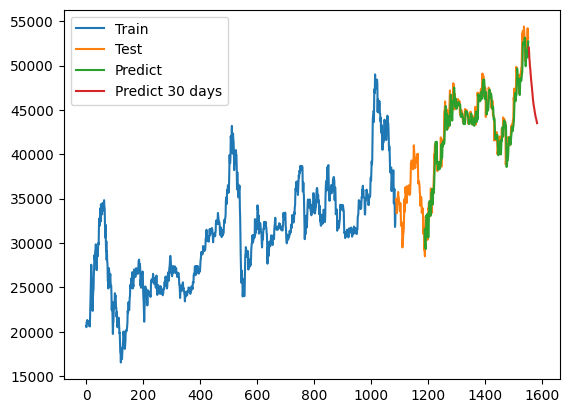

In [80]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 7:3 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6387e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2664e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4406e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3422e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2522e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7902e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5557e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4986e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4782e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4751e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3611e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3618e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━

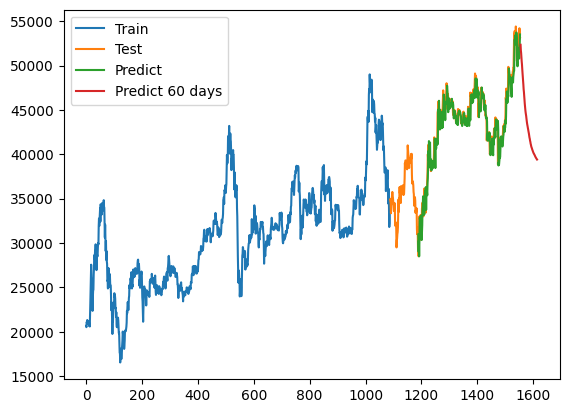

In [81]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 7:3 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0792  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014    
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013    
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011    
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011    
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9

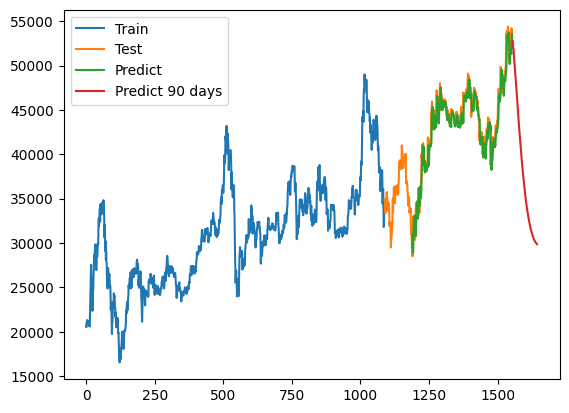

In [82]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3323
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014   
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010   
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4724e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9320e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6881e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5058e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7

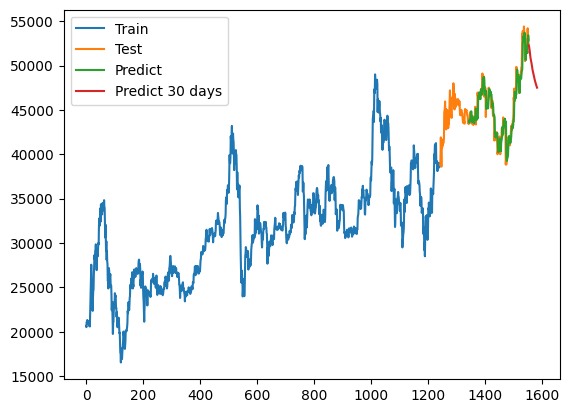

In [83]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 8:2 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1474
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 16/100

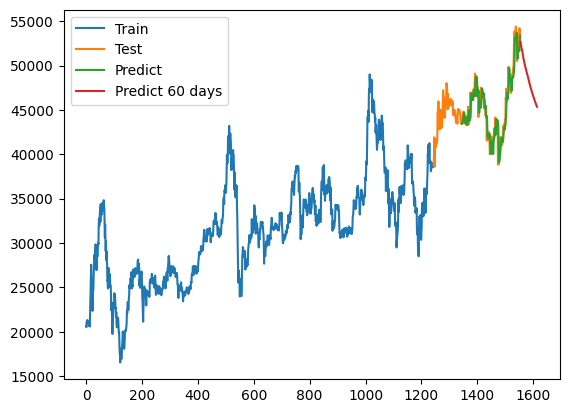

In [84]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 8:2 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5209e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9043e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8307e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9776e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1448e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6054e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2759e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9685e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9715e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6189e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5276e-04
Epoch 15/100
18/18 ━━━━━━━━━━━

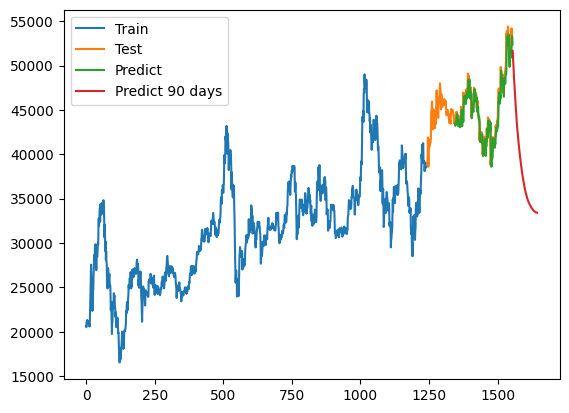

In [85]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3042
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2726e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.09

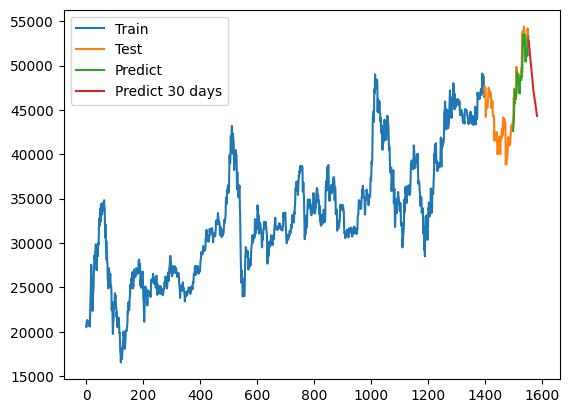

In [86]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**BIDV 9:1 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2510
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
E

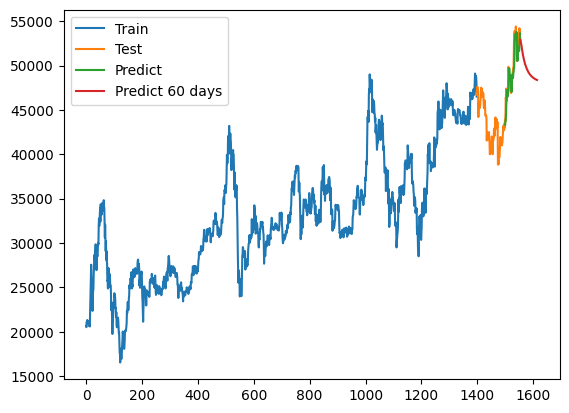

In [87]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**BIDV 9:1 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0807
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8569e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3294e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.1669e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0817e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.2644e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s

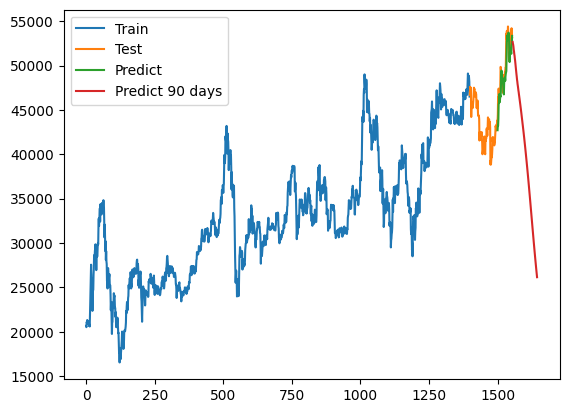

In [88]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

**MBB 7:3 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1854
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.9673e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.6975e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.5678e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.4141e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.5807e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4430e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.7398e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7360e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.4268e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.2997e-04
Epoch 15/100
16/16 ━━━━━━━━━━

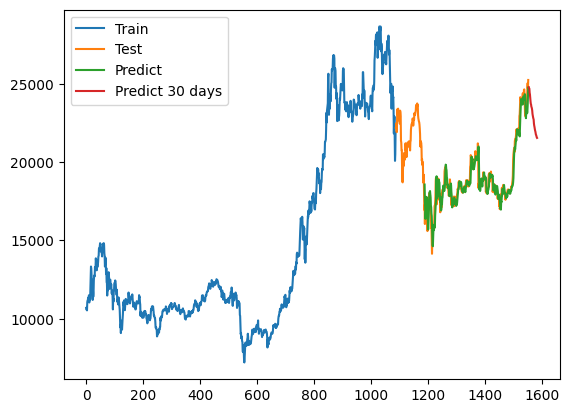

In [89]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 7:3 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0117
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0928e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9117e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.1498e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6274e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1944e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4618e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5757e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3954e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8281e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6398e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6699e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8163e-04
Epoch 15/100
16/16 ━━━━

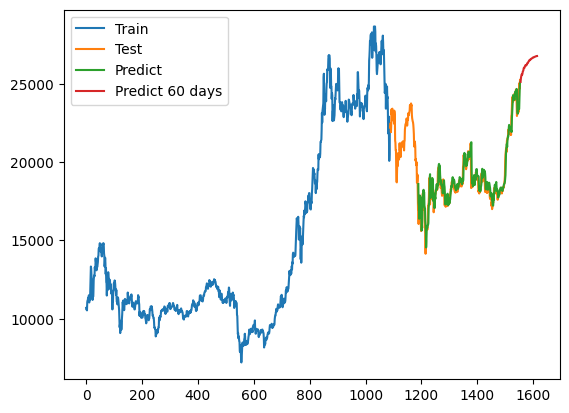

In [90]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 7:3 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1901  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012   
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4688e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6218e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4554e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2578e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0273e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9617e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2841e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0764e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4123e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5586e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6494e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━

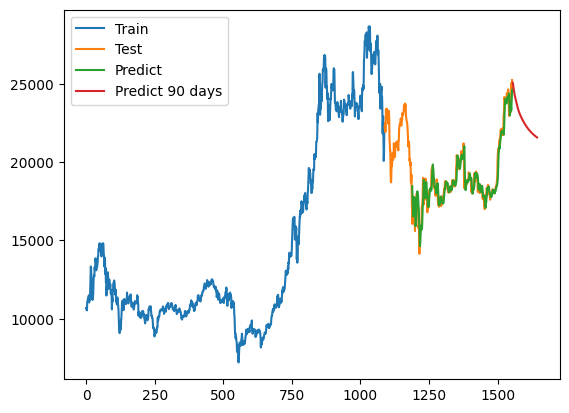

In [91]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1590 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011   
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011   
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010    
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5634e-04 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010  
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2175e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4881e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2732e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7783e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5300e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10

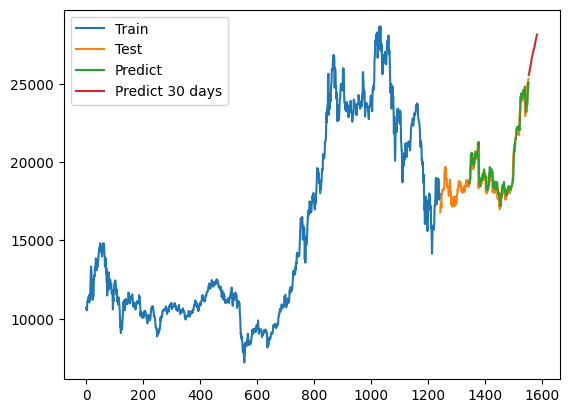

In [92]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 8:2 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0500 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8114e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4549e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3291e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4506e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1421e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0822e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1585e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6206e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8

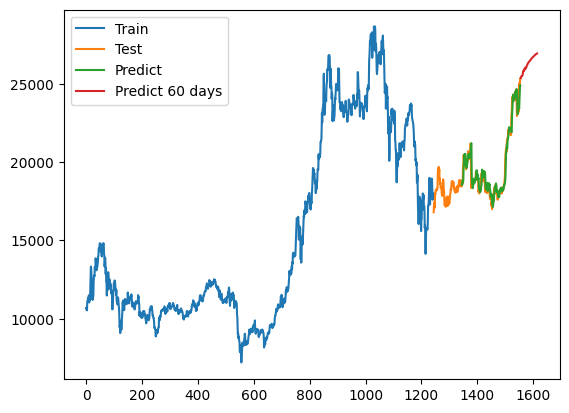

In [93]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 8:2 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0413 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013   
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010   
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.8712e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1925e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2624e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8218e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2065e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

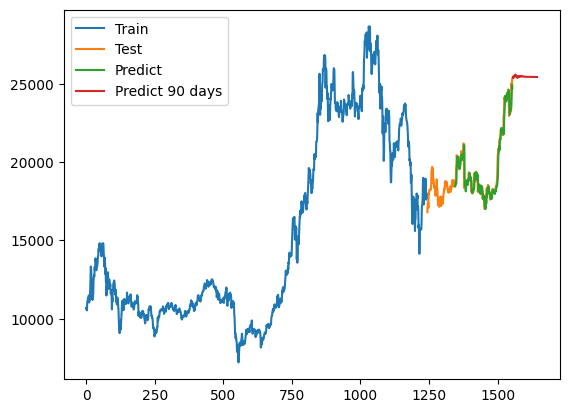

In [94]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0694 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4215e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9401e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5422e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3634e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3791e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1080e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2248e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8099e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9596e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0500e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5516e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9624e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━

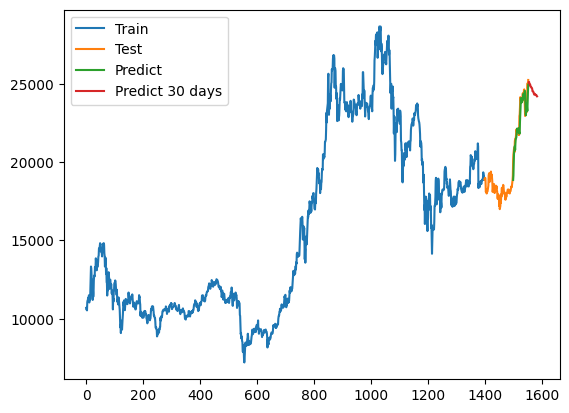

In [95]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**MBB 9:1 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4959e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8106e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7579e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2511e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0800e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5849e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9055e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5395e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9874e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2006e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2166e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2591e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━

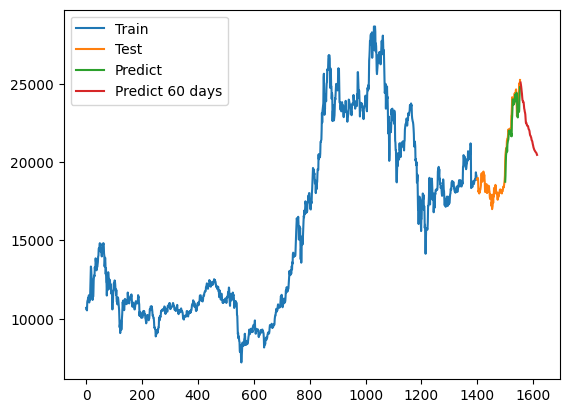

In [96]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**MBB 9:1 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5414 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0315
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010   
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7812e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9880e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9797e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7682e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4303e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7335e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

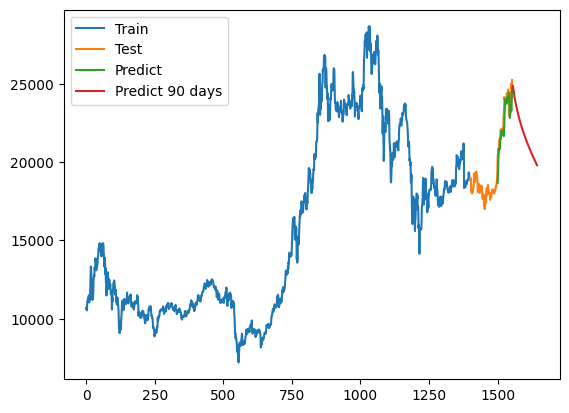

In [97]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

**VCB 7:3 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0307  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2894e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6412e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9702e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6276e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2310e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8733e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2886e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4994e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7525e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9680e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2491e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8008e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━

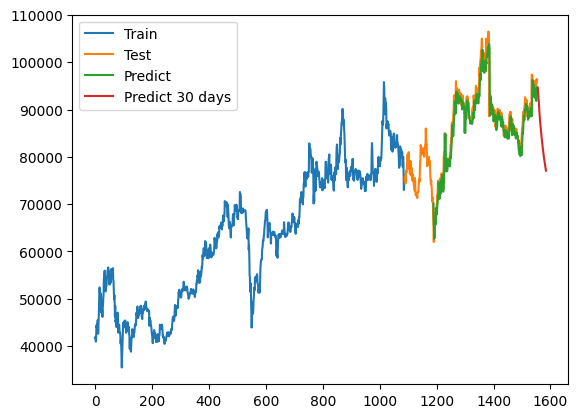

In [98]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 7:3 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1408
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014   
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011   
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010   
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6313e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4684e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2163e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.

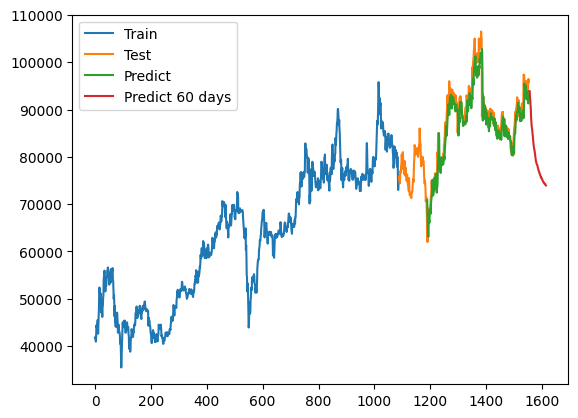

In [99]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 7:3 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0361  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3577e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0027e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3502e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1607e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7856e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7396e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9133e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8023e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7750e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5908e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3963e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━

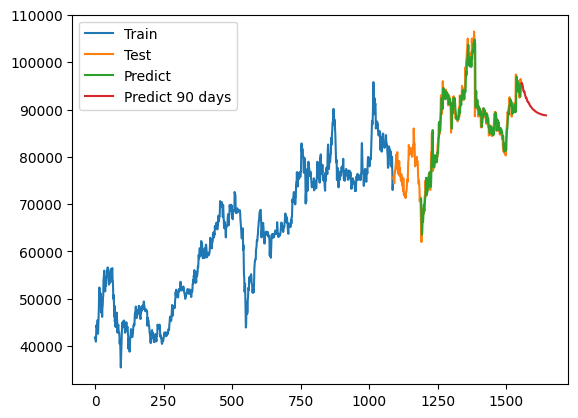

In [100]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3009 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoc

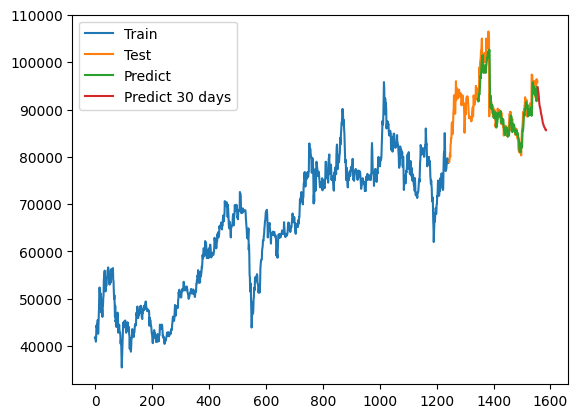

In [101]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 8:2 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2119 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014   
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011   
Epoch 16

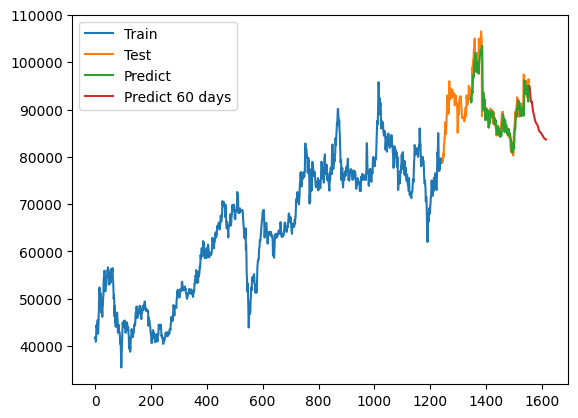

In [102]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 8:2 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0197 
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012   
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7880e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7724e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6629e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4281e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7454e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7778e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9062e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7938e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8976e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4004e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━

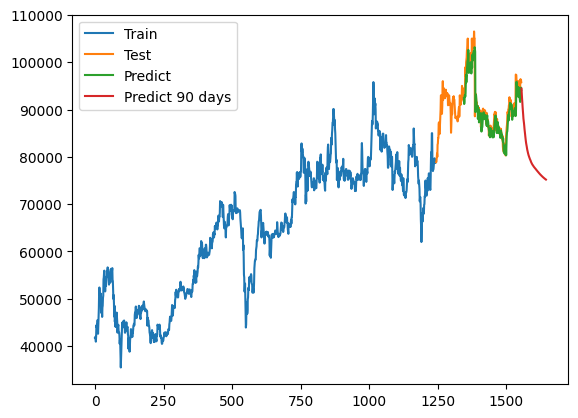

In [103]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 30 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2349
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010  
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9724e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2674e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7798e-04

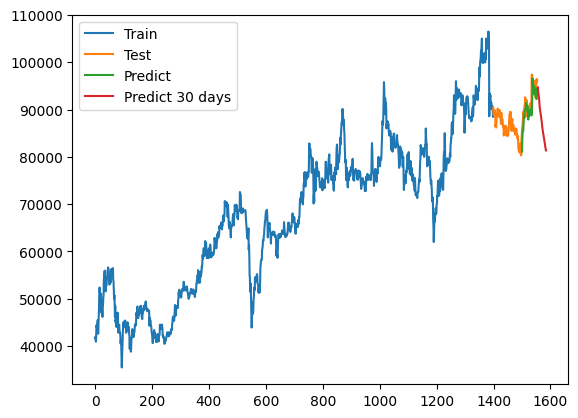

In [104]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

**VCB 9:1 60 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1073
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 16/1

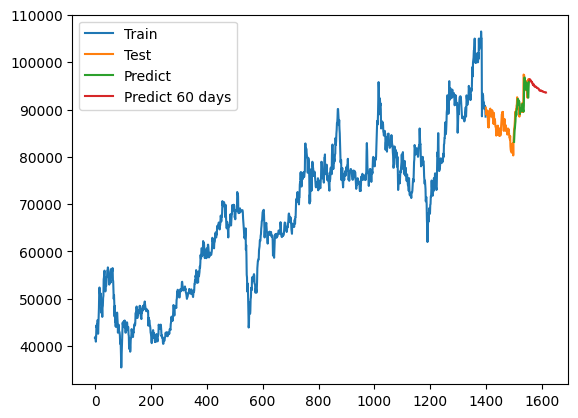

In [105]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

**VCB 9:1 90 days**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0234 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 16/100
2

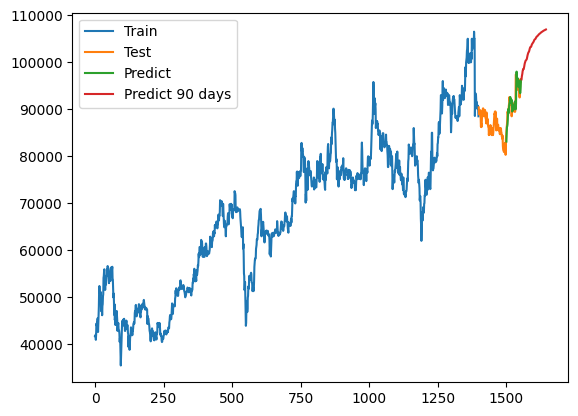

In [106]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)